In [1]:
# Let's import the needed packages for further use ! 
import sys,os

import numpy as np
import copy
import matplotlib.pyplot as plt
plt.ioff()
# %matplotlib notebook

# Jax libraries : AND FITTING librairies ! 
import jax
import optax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
from jax.scipy.special import gammaln,digamma,betaln
from tensorflow_probability.substrates import jax as tfp
from functools import partial

# Our own package to simulate and invert Active Inference models 
import actynf
import actynf.jaxtynf

from actynf.jaxtynf.jax_toolbox import _normalize


# A few helper functions ...
from tools import clever_running_mean
from tools import save_output,extract_training_data
from tools import to_list_of_one_hots
from tools import imshow_with_labels,plot_trials,plot_trials_and_data,plot_trials_new

# Loading the experimental measures !
from load_data import get_all_derivatives_in_order,preprocess_data


# A FEW CONSTANTS : 
XP1_DATA_PATH = os.path.join("data_downloaded","xp1")

subj_names,eeg_data,bold_data,trial_time_stamps = get_all_derivatives_in_order(XP1_DATA_PATH)

c:\Users\annic\OneDrive\Bureau\MainPhD\code\ActivPynference_Public\paper_scripts\paper_grazBCI\tools.py:526: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


([Array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]], dtype=float32), Array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]], dtype=float32)], Array([[0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       ...,
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625]],      dtype=float32), [Array([[[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
    

C:\Users\annic\AppData\Local\Temp\ipykernel_21764\615858084.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


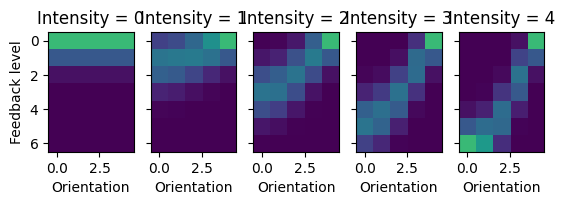

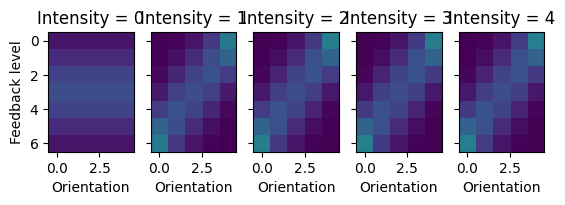

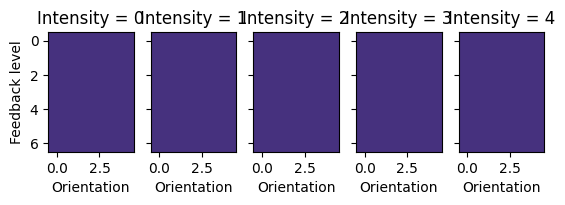

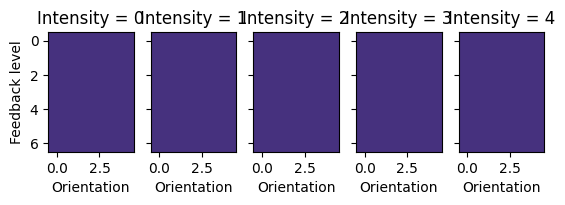

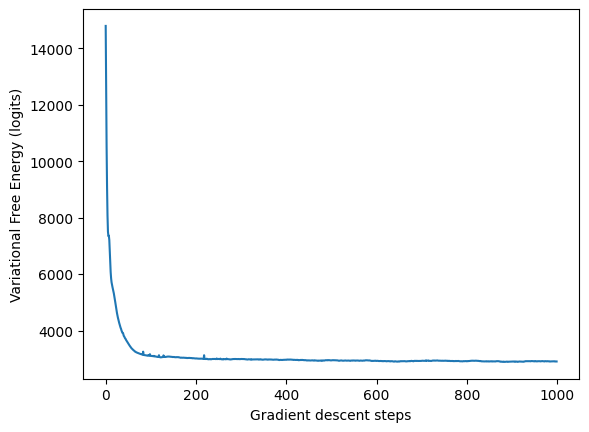

In [9]:
# Function parameters :
Ns = [5,5] # Intensity x orientation
points_per_run = 5   # 2, 5 or 10 (a denominator of 10 !)
Nos = [7,7,7,7]   # i_eeg,o_eeg,i_bold,o_bold
emission_noises = [0.15,0.5,100,100]
emission_prior_strengths = [1000.0,100.0,10.0,10.0]
emission_base_strength = [0.0,0.0,0.0,0.0]

# action_ranges = [jnp.array([-2,-1,0,1,2]),jnp.array([-2,-1,0,1,2])]
action_ranges = [jnp.array([-2,-1,0,1,2]),jnp.array([-2,-1,0,1,2])]
action_ranges = [jnp.array([-4,-3,-2,-1,0,1,2,3,4]),jnp.array([-4,-3,-2,-1,0,1,2,3,4])]
action_ranges = [jnp.arange(0,4),jnp.arange(-2,2)]
# action_ranges = [jnp.array([-1,0,1]),jnp.array([-1,0,1])]
p_drift = [jnp.array([0.3,0.1]),jnp.array([0.3,0.1])]
p_effect = [1.00,1.00]

resting_states = [0,2]
transition_action_strength = [1000.0,1000.0]
transition_base_strength = [0.01,0.01]

initial_state_strength = [1.0,1.0]





# Parameter estimation and model fitting based on those parameters ! 
# Preprocessing :
options = {
    "n_actions_per_run" : points_per_run, 
    "n_outcomes":{
        "i_eeg" : Nos[0],
        "o_eeg" : Nos[1],
        "i_bold" : Nos[2],
        "o_bold" : Nos[3]
    }
}

# Loading the experimental values we're trying to match
data_dictionnary = preprocess_data(eeg_data,bold_data,trial_time_stamps,options)


# Transform this to two list of parameters (values and filters):
observation_values = []
observation_filters = []
for sensor in ["eeg","bold"]:
    for modality in ["intensity","laterality"]:
        o_table = data_dictionnary[sensor][modality]["val"]
        
        Nsubj,Ntasks,Nruns,Npoints,Noutcomes = o_table.shape
        o_table_flattened = jnp.reshape(o_table,(Nsubj,-1,Noutcomes))
        
        observation_values.append(o_table_flattened)

        
        o_filter_table = data_dictionnary[sensor][modality]["filter"]
        o_filter_table_flattened = jnp.reshape(o_filter_table,(Nsubj,-1))
        observation_filters.append(o_filter_table_flattened)
observation_filters = jnp.stack(observation_filters,axis=-1)

# Model : 
from process import get_emission_priors,get_initial_state_priors,get_transition_priors
pA = get_emission_priors(Nos,Ns,
                         emission_noises,emission_prior_strengths,
                         emission_base_strength)

pB = get_transition_priors(Ns,p_drift,p_effect,action_ranges,resting_states,
                           transition_action_strength,transition_base_strength)

pD = get_initial_state_priors(Ns,initial_state_strength)


from tools import plot_a
plot_a(pA,True)

# Main hypothesis : what are the allowable actions for our subject ?
# First, let's assume any action is possible : 
U  =jnp.stack(jnp.meshgrid(jnp.arange(action_ranges[0].shape[0]),jnp.arange(action_ranges[1].shape[0])),axis=-1).reshape((-1,2))

# U  =jnp.array([  [1,0], [0,1], [1,1], [1,2], [2,1] ])
Nu,Nf = U.shape


subject_id = 0
subject_obs = [o[subject_id,...] for o in observation_values]
subject_obs_filter = observation_filters[subject_id,...]


subject_obs_filter = np.array(subject_obs_filter)
# disregard_sensors = [2,3]
# for sensor in disregard_sensors:
#     subject_obs_filter[...,sensor] = 0.0
# subject_obs_filter = jnp.array(subject_obs_filter)

T = subject_obs[0].shape[0]


# Finally, we may assume various kinds of priors regarding what actions were
# performed by the subject at any point.  For now, let's suppose that subjects prefer
# not to perform an active regulation (mental effort)
prior = np.ones((T-1,Nu))
# prior[...,2] = 2.0
pu,_ = _normalize(jnp.array(prior))





def encode_params(_X):
    [_X_qs,_X_qu,_Xa,_Xb] = _X
    

    softmax_tree = lambda x_factor  : jax.nn.softmax(x_factor,-1)
    sigmoid_tree = lambda x_factor : jax.nn.sigmoid(x_factor)
    x_square_tree = lambda x_factor : x_factor*x_factor
    
    
    # noises,emission_strs,emission_bases = _Xa
    # mapped_emission_noises = tree_map(x_square_tree,noises)
    # mapped_str = tree_map(x_square_tree,emission_strs)
    # mapped_bases = tree_map(x_square_tree,emission_bases)
    # a_proposal = get_emission_priors(Nos,Ns,
    #                      mapped_emission_noises,mapped_str,
    #                      mapped_bases)
    
    a_proposal = tree_map(x_square_tree,_Xa)
    
    # p_drifts,transition_strs,transitions_bases = _Xb
    # mapped_drifts = tree_map(sigmoid_tree,p_drifts)
    # mapped_str = tree_map(x_square_tree,transition_strs)
    # # mapped_bases = tree_map(x_square_tree,transitions_bases)
    # mapped_bases = transition_base_strength
    # b_proposal = get_transition_priors(Ns,mapped_drifts,action_ranges,
    #                        mapped_str,mapped_bases)
    b_proposal = tree_map(x_square_tree,_Xb)
    
    _encoded_X = (tree_map(softmax_tree,_X_qs),jax.nn.softmax(_X_qu,-1),a_proposal,b_proposal)
    return _encoded_X

# Smoothing problem only, let's change only the state & latent action
# estimations :
FIXED_PRIORS = (pu,pA,pB,pD,U)
FIXED_POSTERIORS = (pA,pB,pD)

# What do we seek to minimize ? The variational free energy of the Flexible Transition HMM: 
from vfe_minimization import act_hmm_free_energy,fit
def loss_function(params,data):
    _obs_vec, _obs_filter = data
    _s,_u,_a,_b = encode_params(params)
    _,_,_d = FIXED_POSTERIORS
    return act_hmm_free_energy(*((_obs_vec,_obs_filter) + (_s,_u,_a,_b,_d) + FIXED_PRIORS))


start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
data = (subject_obs,subject_obs_filter)

# Initial parameter vectors:
X_qs = [jnp.zeros((T,Ns_f)) for Ns_f in Ns]
X_qu = jnp.zeros((T-1,Nu))
# X_a = [[0.5,0.5,0.5,0.5],[10.0,10.0,10.0,10.0],[1.0,1.0,1.0,1.0]]
# X_b = [[0.5,0.5],[10.0,10.0],[0.0,0.0]]
X_a = [jnp.ones_like(a) for a in pA]
X_b = [jnp.ones_like(b) for b in pB]

# X_qs = [jnp.array(np.random.random((T,Ns_f))) for Ns_f in Ns]
# X_qu = jnp.array(np.random.random((T-1,Nu))) 


X_init = [X_qs,X_qu,X_a,X_b]
print(encode_params(X_init))

final_params,loss_hist = fit(X_init,data,loss_function, optimizer,1000)

fig,ax = plt.subplots(1)
ax.plot(np.arange(0,len(loss_hist),1),loss_hist)
ax.set_xlabel("Gradient descent steps")
ax.set_ylabel("Variational Free Energy (logits)")
fig.show()

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [0 3]
 [1 3]
 [2 3]
 [3 3]]
(3, 100)


C:\Users\annic\AppData\Local\Temp\ipykernel_21764\2843423267.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_21764\2843423267.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_21764\2843423267.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


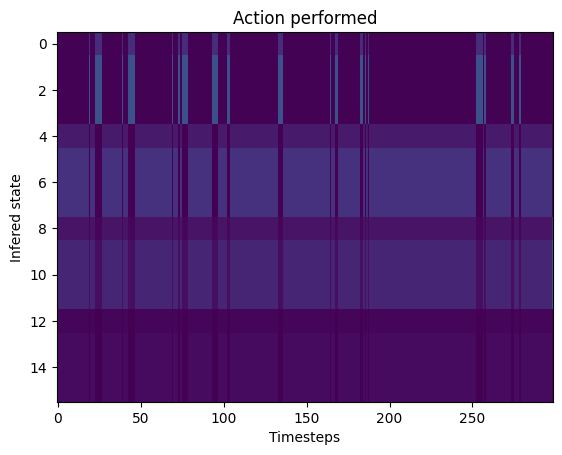

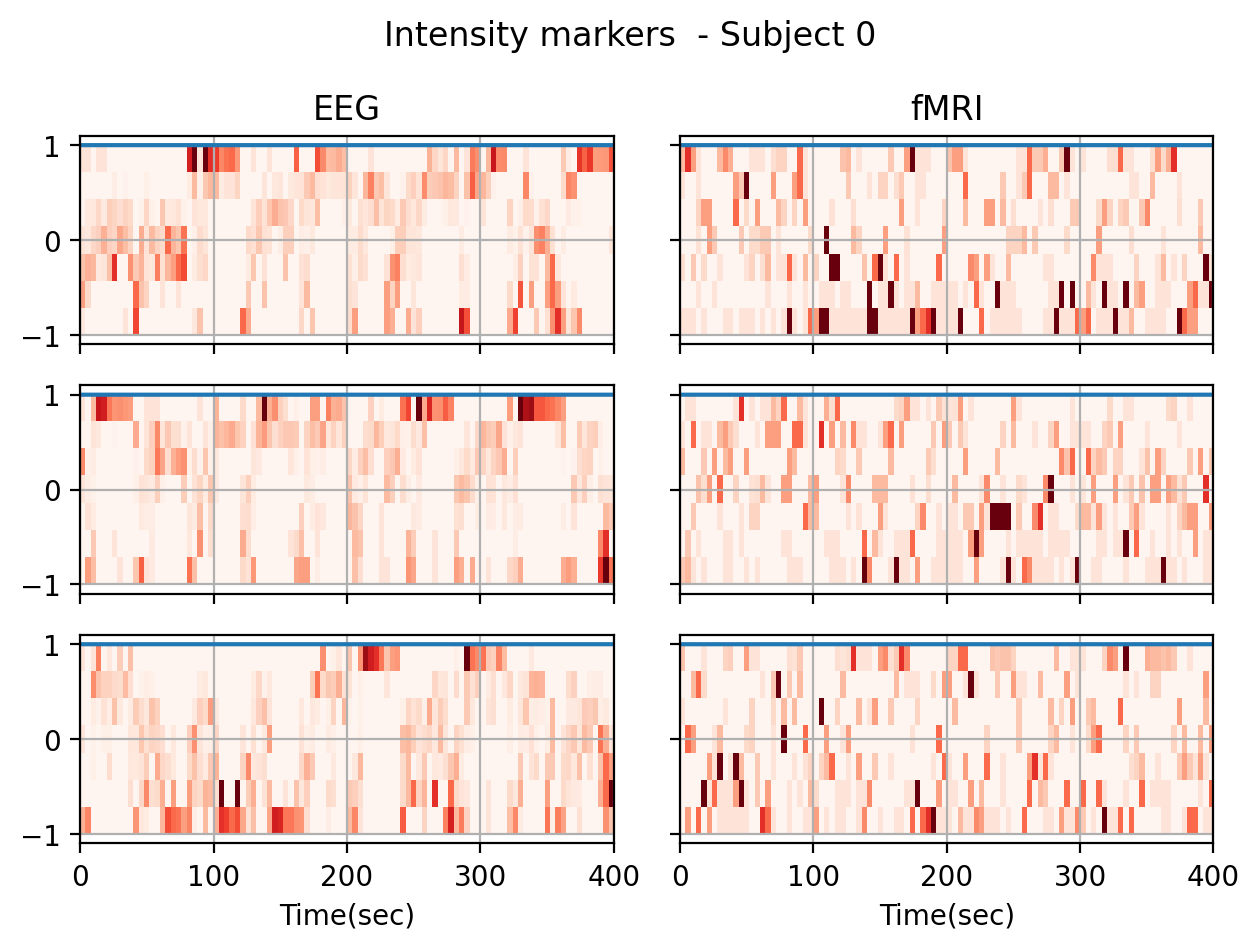

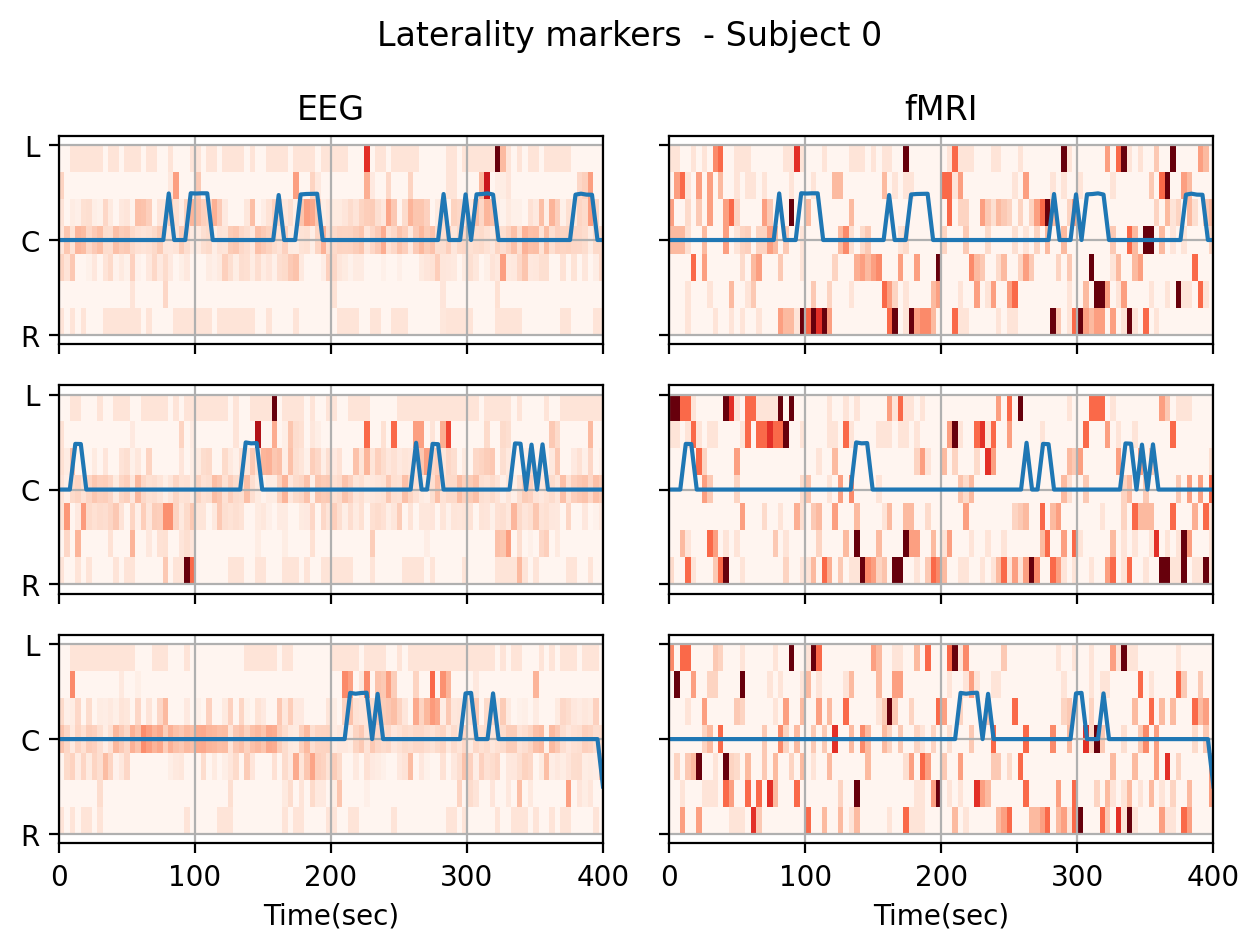

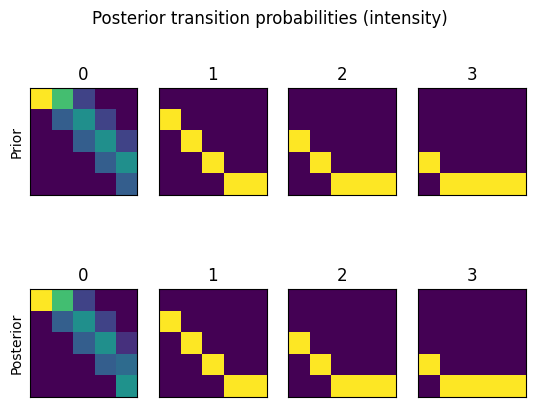

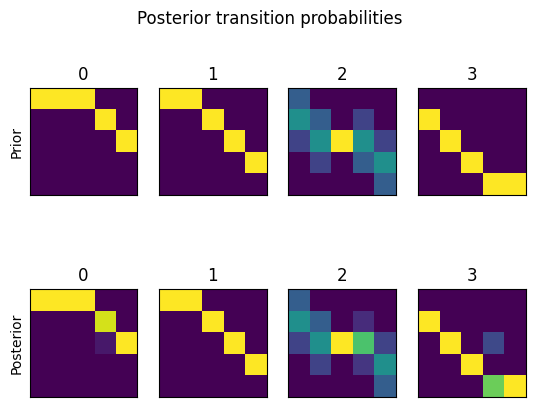

In [8]:

final_qs,final_qu,final_a,final_b = encode_params(final_params)

# print(final_qu)
# print(U)
# plt.imshow(jnp.swapaxes(final_qu,0,1),aspect="auto",interpolation="nearest")
# plt.show()
print(U)

def plot_posterior(x,xlab="x axis",ylab = "y axis",titl= "default title"):
    fig,ax = plt.subplots(1)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(titl)
    ax.imshow(x,aspect="auto",interpolation="nearest",vmin=0.0,vmax=1.0)
    fig.show()
    
# plot_posterior(jnp.swapaxes(final_qs[0],0,1),"Timesteps","Infered state","Intensity")
# plot_posterior(jnp.swapaxes(final_qs[1],0,1),"Timesteps","Infered state","Orientation")
plot_posterior(jnp.swapaxes(final_qu,0,1),"Timesteps","Infered state","Action performed")

Nsubj,Ntasks,Nruns,Npoints,_ = data_dictionnary["eeg"]["intensity"]["val"].shape


# Compute the expected values :
reshaped_posteriors = []

intensity_hidden_state = final_qs[0]
Ncat = intensity_hidden_state.shape[-1]
expected_value_intensity = jnp.einsum("i,ti->t",jnp.linspace(-1,1,Ncat),intensity_hidden_state)   
reshaped_posteriors.append(jnp.reshape(expected_value_intensity,(Ntasks,-1)))

laterality_hidden_state = final_qs[1]
Ncat = laterality_hidden_state.shape[-1]
expected_value_laterality = jnp.einsum("i,ti->t",jnp.linspace(1,-1,Ncat),laterality_hidden_state)  
    # Inverted because for orientation, lower categories are the left hand side 
reshaped_posteriors.append(jnp.reshape(expected_value_laterality,(Ntasks,-1)))

print(reshaped_posteriors[-1].shape)



# Intensity plot :
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,dpi=200)
fig.suptitle("Intensity markers  - Subject {}".format(subject_id))

axes[0,0].set_title("EEG")
axes[0,1].set_title("fMRI")
axes[-1,0].set_xlabel("Time(sec)")
axes[-1,1].set_xlabel("Time(sec)")

o_bold_int =  data_dictionnary["bold"]["intensity"]["val"]
o_eeg_int = data_dictionnary["eeg"]["intensity"]["val"]

for task in range(3) :     
    # EEG PLOT 
    ax_eeg = axes[task,0]
    flat_img = np.swapaxes(np.reshape(o_eeg_int[subject_id,task,...],(-1,o_eeg_int.shape[-1])),0,1)
    flipped = np.flip(flat_img,axis=0)
    ax_eeg.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
    ax_eeg.set_ylim([-1.1,1.1])
    ax_eeg.grid()
    
    # BOLD PLOT :
    ax_bold = axes[task,1]
    flat_img = np.swapaxes(np.reshape(o_bold_int[subject_id,task,...],(-1,o_bold_int.shape[-1])),0,1)     
    flipped = np.flip(flat_img,axis=0)
    ax_bold.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
    ax_bold.set_ylim([-1.1,1.1])
    ax_bold.grid()
    
    posterior_task = reshaped_posteriors[0][task,:]
    for ax in axes[task,:] : 
        
        ax.plot(np.linspace(0,400,posterior_task.shape[0]),posterior_task)
fig.tight_layout()
fig.show()


# Laterality plot :
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,dpi=200)
fig.suptitle("Laterality markers  - Subject {}".format(subject_id))

axes[0,0].set_title("EEG")
axes[0,1].set_title("fMRI")
axes[-1,0].set_xlabel("Time(sec)")
axes[-1,1].set_xlabel("Time(sec)")

o_bold_lat =  data_dictionnary["bold"]["laterality"]["val"]
o_eeg_lat = data_dictionnary["eeg"]["laterality"]["val"]

for task in range(3) :     
    # EEG PLOT 
    ax_eeg = axes[task,0]
    flat_img = np.swapaxes(np.reshape(o_eeg_lat[subject_id,task,...],(-1,o_eeg_lat.shape[-1])),0,1)
    flipped = np.flip(flat_img,axis=0)
    ax_eeg.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
    ax_eeg.set_ylim([-1.1,1.1])
    ax_eeg.set_yticks([-1.0,0.0,1.0])
    ax_eeg.set_yticklabels(["R","C","L"])
    ax_eeg.grid()
    
    # BOLD PLOT :
    ax_bold = axes[task,1]
    flat_img = np.swapaxes(np.reshape(o_bold_lat[subject_id,task,...],(-1,o_bold_lat.shape[-1])),0,1)     
    flipped = np.flip(flat_img,axis=0)
    ax_bold.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
    ax_bold.set_ylim([-1.1,1.1])
    ax_bold.grid()
    ax_bold.set_yticks([-1.0,0.0,1.0])
    ax_bold.set_yticklabels(["R","C","L"])
    
    posterior_task = reshaped_posteriors[1][task,:]
    for ax in axes[task,:] : 
        
        ax.plot(np.linspace(0,400,posterior_task.shape[0]),posterior_task)

fig.tight_layout()
fig.show()


# Intensity :
b_prior = pB[0]
b_final = final_b[0]

ks = b_prior.shape[-1]
fig,axes = plt.subplots(2,ks)
fig.suptitle("Posterior transition probabilities (intensity)")
axes[0,0].set_ylabel("Prior")
axes[1,0].set_ylabel("Posterior")
for k in range(ks):
    ax = axes[0,k]
    ax.set_title("{}".format(k) )
    ax.imshow(_normalize(b_prior[...,k])[0],vmin=0.0,vmax=1.0)
    # for major ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)
    # for major ticks
    ax.set_yticks([])
    # for minor ticks
    ax.set_yticks([], minor=True)
    
    
    ax = axes[1,k]
    ax.set_title("{}".format(k) )
    ax.imshow(_normalize(b_final[...,k])[0],vmin=0.0,vmax=1.0)
    # for major ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)
    # for major ticks
    ax.set_yticks([])
    # for minor ticks
    ax.set_yticks([], minor=True)
plt.show()


# Laterality :
b_prior = pB[1]
b_final = final_b[1]

fig,axes = plt.subplots(2,ks)
fig.suptitle("Posterior transition probabilities")
axes[0,0].set_ylabel("Prior")
axes[1,0].set_ylabel("Posterior")
for k in range(ks):
    ax = axes[0,k]
    ax.set_title("{}".format(k) )
    ax.imshow(_normalize(b_prior[...,k])[0],vmin=0.0,vmax=1.0)
    # for major ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)
    # for major ticks
    ax.set_yticks([])
    # for minor ticks
    ax.set_yticks([], minor=True)
    
    
    ax = axes[1,k]
    ax.set_title("{}".format(k) )
    ax.imshow(_normalize(b_final[...,k])[0],vmin=0.0,vmax=1.0)
    # for major ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)
    # for major ticks
    ax.set_yticks([])
    # for minor ticks
    ax.set_yticks([], minor=True)
plt.show()


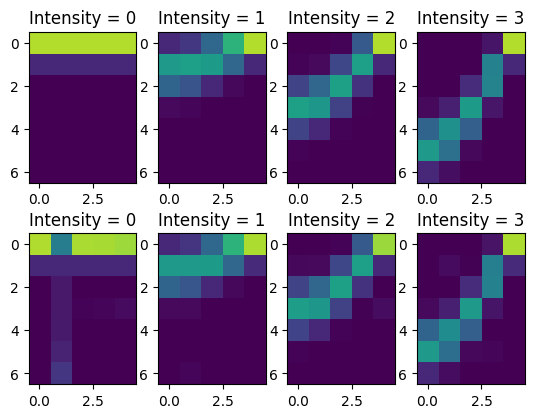

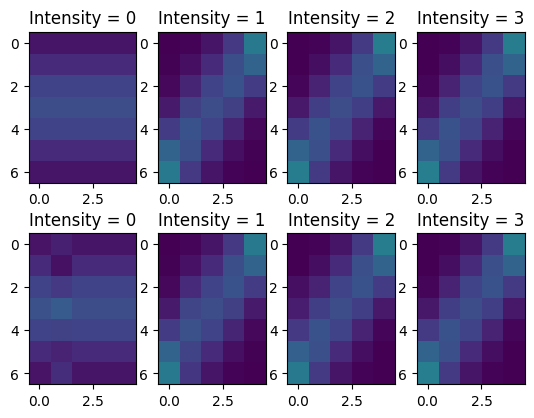

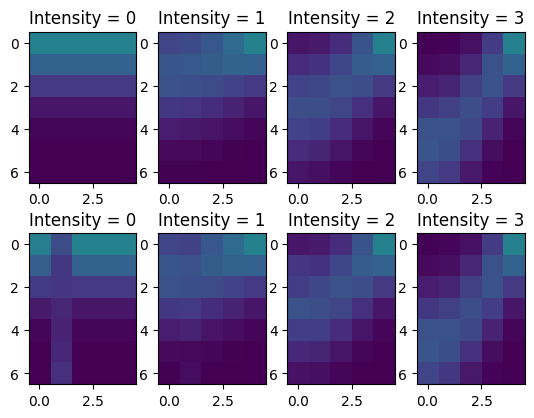

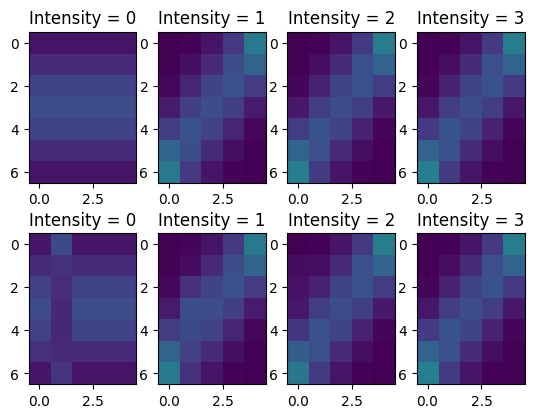

In [ ]:

for modality,(prior_a,posterior_a) in enumerate(zip(pA,final_a)):
    # # Plot the matrices if needed :
    # print(feedback_matrix.shape)
    fig,axes = plt.subplots(2,4)
    # fig.suptitle(sensor[modality] + "  - biomarker " +type[modality],y=0.75)
    
    # Prior :
    axs = axes[0,:]
    for i,ax in enumerate(axs) : 
        ax.set_title("Intensity = {}".format(i))
        ax.imshow(np.array(_normalize(prior_a[:,i,:])[0]),vmin=0.0,vmax=1.0)
    
    # Posterior :
    axs = axes[1,:]
    for i,ax in enumerate(axs) : 
        ax.set_title("Intensity = {}".format(i))
        ax.imshow(np.array(_normalize(posterior_a[:,i,:])[0]),vmin=0.0,vmax=1.0)
    
    # # fig.show()
    plt.show()

In [ ]:
print(final_params[-2])


print(final_params[-1])

[Array([[[ 8.3986378e+00,  8.9485207e+00,  8.7771931e+00,  9.8814249e+00,
          8.9059076e+00],
        [ 3.3909874e+00,  4.9472556e+00,  5.2178960e+00,  6.9482107e+00,
          6.8497610e+00],
        [ 4.7022292e-01,  1.6715938e-01,  9.8694384e-01,  4.8454313e+00,
          8.0446959e+00],
        [ 2.8032478e-02,  4.6272292e-03,  3.9017756e-02,  2.9359460e+00,
          7.0167623e+00],
        [-1.2405612e-01, -6.7734882e-02, -2.7221117e-02,  6.5126354e-01,
          6.9164019e+00]],

       [[ 3.0378137e+00,  4.7107887e+00,  3.1880083e+00,  3.5798590e+00,
          3.2686288e+00],
        [ 7.2846384e+00,  9.2814665e+00,  6.6362953e+00,  4.9736423e+00,
          2.5170751e+00],
        [ 1.3274083e+00,  1.7264285e+00,  4.3315506e+00,  6.8343120e+00,
          2.9647214e+00],
        [-2.2730809e-01, -1.8822737e+00,  6.0488957e-01,  8.2917585e+00,
          2.5780649e+00],
        [-8.9961123e-03,  1.0394848e-02, -5.5737007e-01,  3.4598119e+00,
          2.5396140e+00]],

     